# [book](https://nbviewer.org/github/fastai/fastbook/blob/master/15_arch_details.ipynb)

In [2]:
dependencies = [
    "fastai"
]

!pip install -U {" ".join(dependencies)}

from fastai.imports import *

In [3]:
import pandas as pd

results_df = pd.DataFrame(columns=['very first', 'head', 'body'])

def track_results(experiment_name, result, reset=False):
    global results_df
    if reset:
        results_df = pd.DataFrame(columns=[''])
    results_df.loc[experiment_name] = result
    return results_df

In [4]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")
files[0]

Path('/Users/cactus/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg')

# Training A Siamese Model

### [Also See Training A Siamese Model](https://docs.fast.ai/tutorial.siamese.html#train-the-model)

In [5]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

labels = list(set(files.map(label_func)))

### Transforming Files to Custom Type

In [6]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs):
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)


class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [{l: [f for f in files[splits[i]] if label_func(f) == l] for l in labels}
                          for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}

    def encodes(self, f):
        f2,same = self.valid.get(f, self._draw(f,0))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, int(same))

    def _draw(self, f, split=0):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls))
        return random.choice(self.splbl2files[split][cls]),same


### Model

In [7]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head

    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

### Using a Pretrained Model

In [8]:
meta = model_meta[resnet18]
meta, meta['weights'], meta['cut']

({'cut': -2,
  'split': <function fastai.vision.learner._resnet_split(m)>,
  'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
  'weights': 'DEFAULT'},
 'DEFAULT',
 -2)

In [25]:
resnet34((weights=meta['weights']))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
encoder = create_body(resnet34(weights=meta['weights']), pretrained=True, cut=meta['cut'])
encoder
#if you scroll all the way down we will see that the last two layers disappeared

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [28]:
head = create_head(512*2, 2, ps=0.5)
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [30]:

model = SiameseModel(encoder, head)
model
#if you scroll all the way down we will see the new head

SiameseModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [11]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor],
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*meta['stats'])])

b = dls.one_batch()
explode_types(b)

{__main__.SiameseImage: [fastai.torch_core.TensorImage,
  fastai.torch_core.TensorImage,
  torch.Tensor]}

In [12]:
b[0].shape, b[1].shape, b[2].shape

(torch.Size([64, 3, 224, 224]),
 torch.Size([64, 3, 224, 224]),
 torch.Size([64]))

### Fixing show_batch()

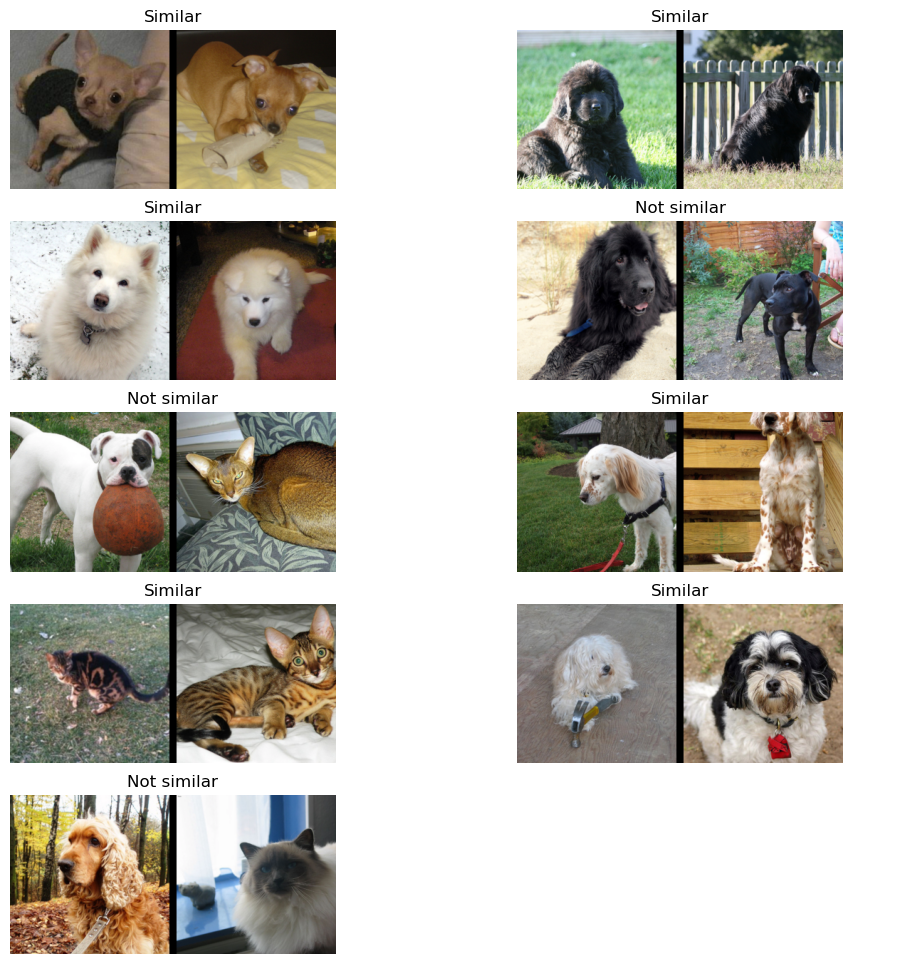

In [13]:
# we need to create a new version of show_batch
# that knows how to handle input that is of type SiameseImage

@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

dls.show_batch()

In [14]:
valids = [v[0] for k,v in tfm.valid.items()]
assert not [v for v in valids if v in files[splits[0]]]

### Train the model

In [15]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())
try:
  del learn
except:
  pass
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter, metrics=accuracy).to_fp16()
# Since we are not using a convenience function
# that directly creates the Learner for us, we need to freeze it manually:
# Since we are not using vision_learner or other convenience from fastai
# we need to immediately freeze the model's body before training
# so that we can focus on training the head
learn.freeze()

In [16]:
# just train for one epoch just to get an idea of the starting point
learn.fit_one_cycle(1, 3e-3)

/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time


/Users/cactus/miniconda3/lib/python3.12/site-packages/fastai/learner.py:448: SyntaxWarning: invalid escape sequence '\R'
  e.args = [f"Custom classes or functions exported with your `Learner` not available in namespace.\Re-declare/import before loading:\n\t{e.args[0]}"]


KeyboardInterrupt: 

In [ ]:
track_results('ALL FROM META + custom loss_func', ['0.859', '', ''])
track_results('ALL FROM META + CrossEntropyLossFlat', ['0.893', '', ''])
track_results('create_body(resnet34(), pretrained=True,  cut=meta[cut])', ['0.52', '', ''])
track_results('no normalization from stats', ['0.86', '', ''])

,very first,head,body
ALL FROM META + custom loss_func,0.859,,
ALL FROM META + CrossEntropyLossFlat,0.893,,
"create_body(resnet34(), pretrained=True, cut=meta[cut])",0.52,,
no normalization from stats,0.86,,


In [ ]:
# FOR REAL NOW!
try:
  del learn
except:
  pass
learn = Learner(dls, model, loss_func=loss_func, splitter=siamese_splitter, metrics=accuracy).to_fp16()
# Since we are not using a convenience function
# that directly creates the Learner for us, we need to freeze it manually:
# Since we are not using vision_learner or other convenience from fastai
# we need to immediately freeze the model's body before training
# so that we can focus on training the head
learn.freeze()

# train the head for 4 epochs
learn.fit_one_cycle(4, 3e-3)

# We can now unfreeze all weights and the full model for a few more epochs
# with discriminative learning rates
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.375624,0.358661,0.845737,01:27
1,0.349826,0.250020,0.906631,01:29
2,0.281093,0.193802,0.922192,01:21
3,0.248687,0.188247,0.928958,01:24


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,accuracy,time
0,0.233382,0.181539,0.931664,01:23
1,0.225468,0.175418,0.935047,01:27
2,0.221716,0.173749,0.935047,01:31
3,0.220903,0.175257,0.935047,01:25


In [ ]:
track_results('create_body(resnet34(weights=meta[weights]), pretrained=True, cut=meta[cut])', ['0.928', '0.931', '0.933'])

,very first,head,body
ALL FROM META + custom loss_func,0.859,,
ALL FROM META + CrossEntropyLossFlat,0.893,,
"create_body(resnet34(), pretrained=True, cut=meta[cut])",0.52,,
no normalization from stats,0.86,,
"create_body(resnet34(weights=meta[weights]), pretrained=True, cut=meta[cut])",0.88,0.934,0.933


### Making show_results work

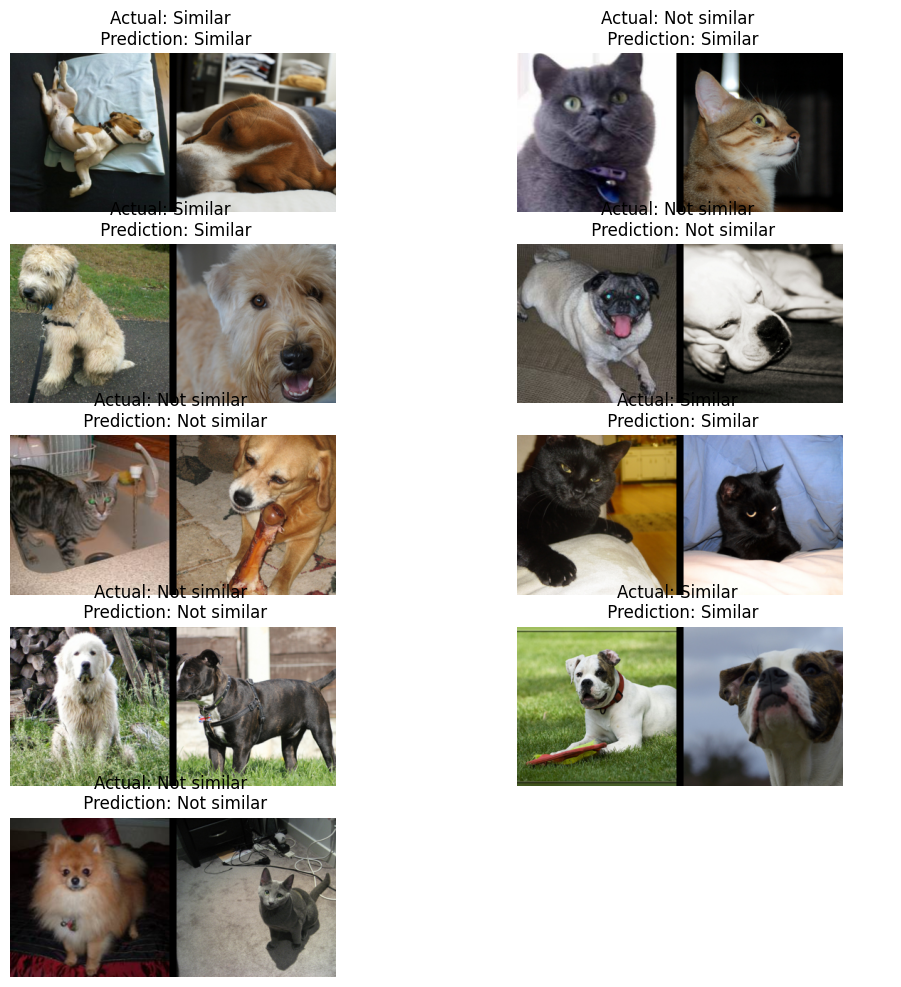

In [ ]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs):
      similarOrNot = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][y[2][i].argmax()]}'
      SiameseImage(x[0][i], x[1][i], similarOrNot).show(ctx=ctx)

learn.show_results()

In [ ]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_top_losses(5, nrows=1)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


TypeError: loss_func() got an unexpected keyword argument 'reduction'

### Custom Predict Function

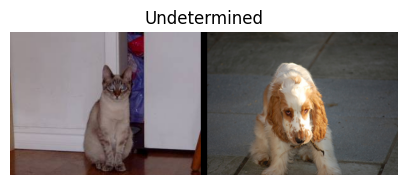

In [ ]:
imgtest = PILImage.create(files[0])
imgval = PILImage.create(files[100])
siamtest = SiameseImage(imgval, imgtest)
siamtest.show();

(tensor([ 3.2090, -3.1328]),
 tensor([ 3.2090, -3.1328]),
 tensor([ 3.2090, -3.1328]))

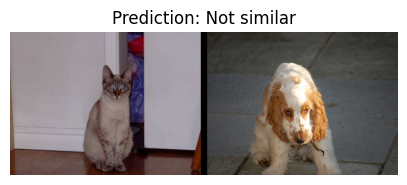

In [ ]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    if res[0].argmax() == tensor(0):
        SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
    else:
        SiameseImage(item[0], item[1], 'Prediction: Similar').show()
    return res

learn.siampredict(siamtest)

# unet_learner

# NLP

In [18]:
REVIEW https://nbviewer.org/github/fastai/fastbook/blob/master/15_arch_details.ipynb

SyntaxError: invalid decimal literal (407625034.py, line 1)

# Tabular

all of this doesn't matter we ust want a tabular learner to check the layers

In [14]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    %pip install -Uq fastkaggle

from fastkaggle import *

from fastai.imports import *
from fastai.tabular.all import *

np.set_printoptions(linewidth=110)

comp = 'titanic'
path = setup_comp(comp, install='fastai')

path.ls(file_type='text')
df = pd.read_csv(path/'train.csv', low_memory=False)
tst_df = pd.read_csv(path/'test.csv', low_memory=False)


# quick and dirty preprocessing,
# cuz that's not the point of this notebook to get good results here
modes = df.mode().iloc[0]
df.fillna(modes, inplace=True)
tst_df.fillna(modes, inplace=True)

def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

df = pd.read_csv(path/'train.csv')
add_features(df)
splits = RandomSplitter(seed=42)(df)


dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=path)

learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])


/Users/cactus/miniconda3/lib/python3.12/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [7]:
class TabularModel(Module):
    def forward(self, x_cat, x_cont=None):
        if self.n_emb != 0: # if there are discrete variables to deal with
            # 1. get the ectivations for each embeddings
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]

            # 2. concatenate the discrete variables into a single tensor
            x = torch.cat(x, 1)    
            
            # 3. apply a dropout layer for regularization
            x = self.emb_drop(x)

        if self.n_cont != 0: # if there are continuous variables to deal with
            # 1. Continuous variables are passed through a batchnorm layer:
            x_cont = self.bn_cont(x_cont)

            # 2. Concate with the embedding activations 👆if any
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont

        # finally this is passed through the linear layer
        return self.layers(x)

let's compare with what the fastai library did

In [16]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1-3): 3 x Embedding(4, 3)
    (4): Embedding(5, 4)
    (5): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=26, out_features=10, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=10, out_features=10, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [17]:
# (embeds): ModuleList(
#     (0): Embedding(3, 3)
#     (1-3): 3 x Embedding(4, 3)
#     (4): Embedding(5, 4)
#     (5): Embedding(3, 3)
#   )
# corresponds to...
# 2. concatenate the discrete variables into a single tensor
# x = torch.cat(x, 1)  
# ["Sex","Pclass","Embarked","Deck", "Title"]

# (emb_drop): Dropout(p=0.0, inplace=False) corresponds to
# x = self.emb_drop(x)

# (bn_cont): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) corresponds to
# 1. Continuous variables are passed through a batchnorm layer:
# x_cont = self.bn_cont(x_cont)
# ['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family']